In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


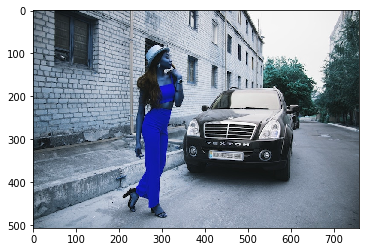

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import cv2

img = cv2.imread("/content/drive/My Drive/woman-with-car.jpg", cv2.IMREAD_COLOR)
plt.imshow(img); plt.show()


In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (255, 255, 255), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [0]:
from google.colab import files
import torchvision.transforms as T
import numpy as np

def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()
  cv2.imwrite('mask2.png' , rgb)
  files.download('mask2.png')
  return rgb



In [6]:
from torchvision import models

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 361MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 115MB/s]


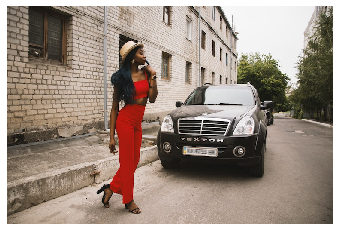

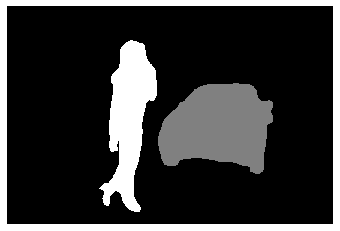

In [42]:

rgb=segment(dlab, '/content/drive/My Drive/woman-with-car.jpg')

In [0]:
rgb[rgb!=255]=0

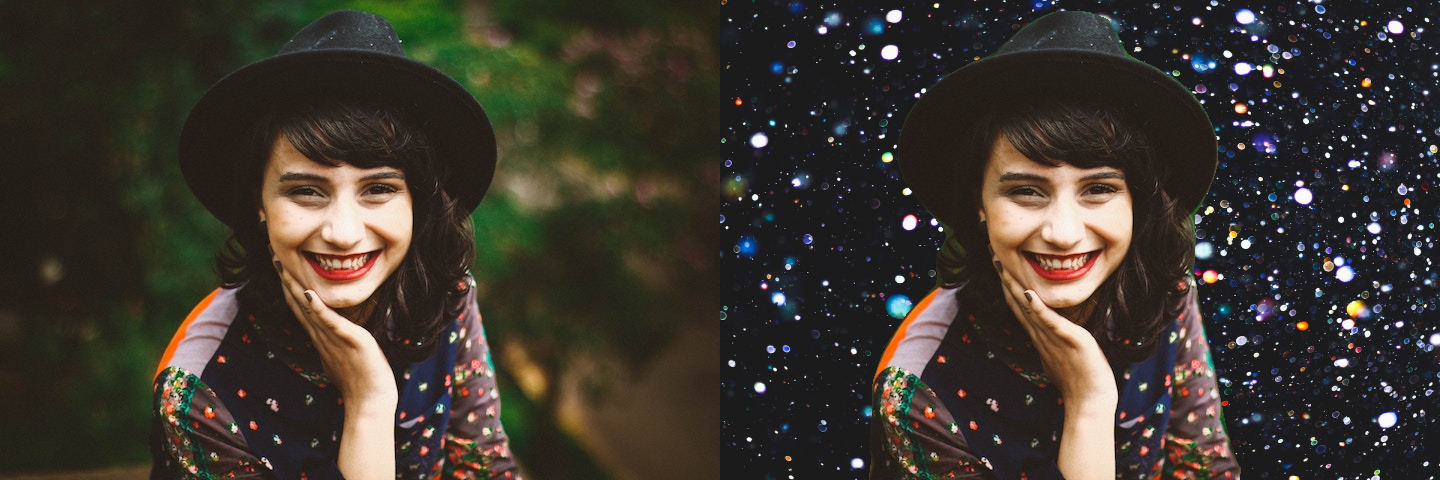

In [9]:
#alpha blending to customize the background of the image
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Read the images
foreground = cv2.imread("/content/drive/My Drive/girl8.jpg")
background = cv2.imread("/content/drive/My Drive/light.jpg", cv2.IMREAD_COLOR)
background = cv2.resize(background, (rgb.shape[1],rgb.shape[0]), interpolation = cv2.INTER_AREA)

alpha = rgb

# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 

 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
 
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
 
# Add the masked foreground and background.
outImage = cv2.add(foreground, background)
 
numpy_horizontal = np.hstack((img, outImage))

numpy_horizontal_concat = np.concatenate((img, outImage), axis=1)
# Display image
cv2_imshow(numpy_horizontal_concat)
cv2.waitKey(0)
# Display image
cv2.imwrite('res.png' , numpy_horizontal_concat)
files.download('res.png')





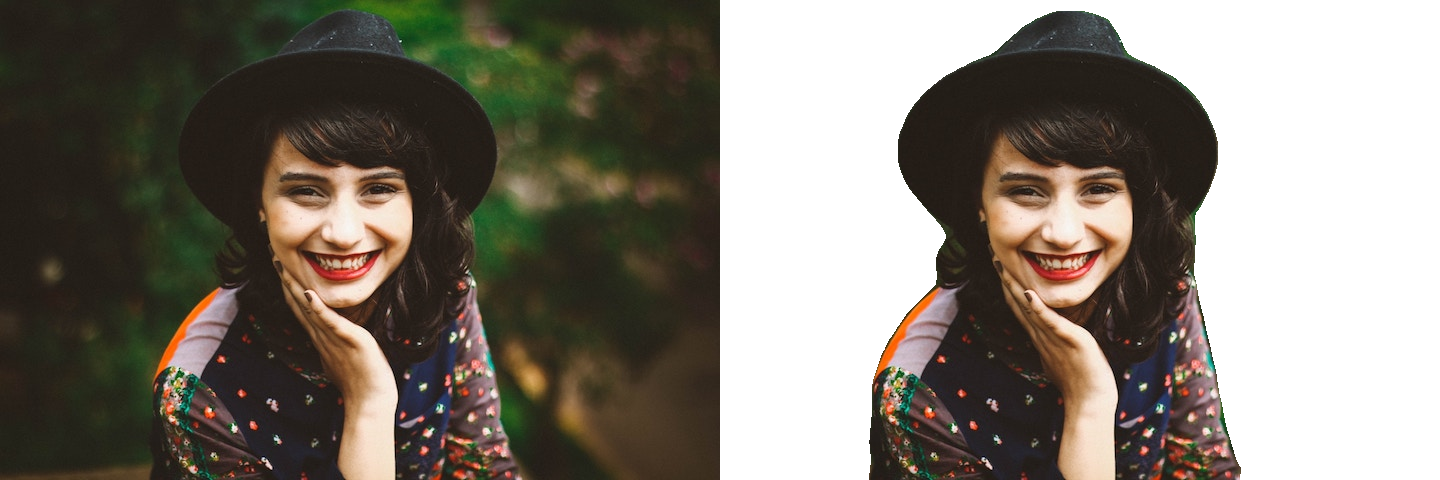

In [12]:
#whiten the background of the image
import cv2
from google.colab.patches import cv2_imshow

mask_out=cv2.subtract(rgb,img)
mask_out=cv2.subtract(rgb,mask_out)
mask_out[rgb == 0] = 255
#plt.imshow(mask_out); plt.show()
cv2.imwrite('out4.jpeg' , mask_out)
numpy_horizontal = np.hstack((img, mask_out))

numpy_horizontal_concat = np.concatenate((img, mask_out), axis=1)
# Display image
cv2_imshow(numpy_horizontal_concat)
cv2.waitKey(0)
# Display image
cv2.imwrite('res.png' , numpy_horizontal_concat)
files.download('res.png')

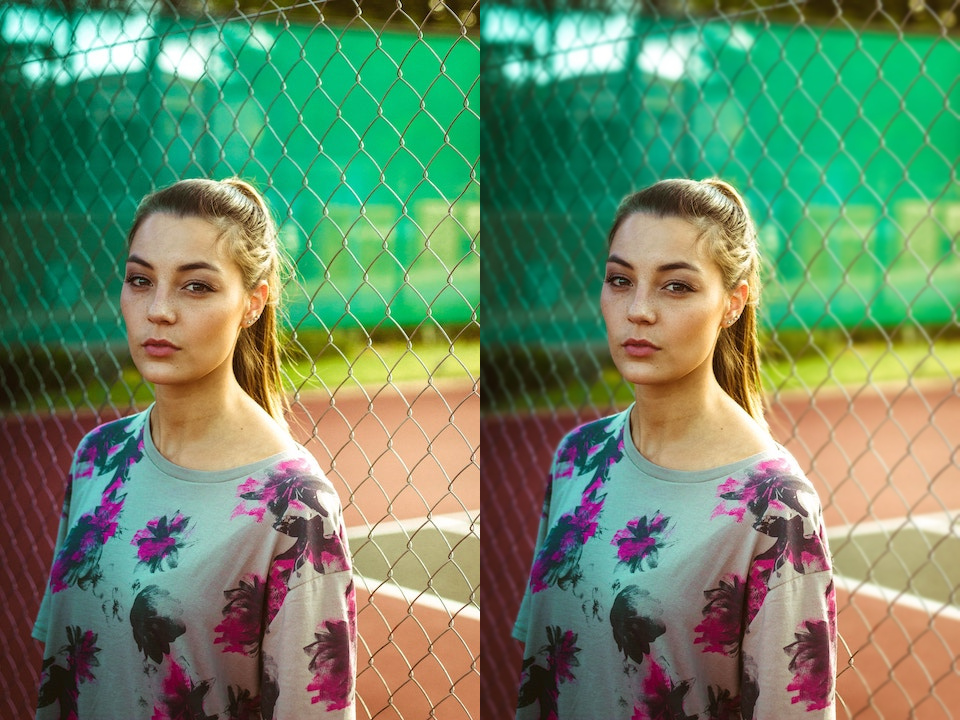

In [17]:
# Read the images
foreground = cv2.imread("/content/drive/My Drive/girl8.jpg")

# Create a Gaussian blur of kernel size 7 for the background image
blurredImage = cv2.GaussianBlur(foreground, (7,7), 0)

# Convert uint8 to float
foreground = foreground.astype(float)
blurredImage = blurredImage.astype(float)

# Create a binary mask of the RGB output map using the threshold value 0
th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

# Apply a slight blur to the mask to soften edges
alpha = cv2.GaussianBlur(alpha, (7,7),0)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)

# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, blurredImage)

 
# Add the masked foreground and background
outImage = cv2.add(foreground, background)
 
# Return a normalized output image for display
outImage= outImage#/255
numpy_horizontal = np.hstack((img, outImage))

numpy_horizontal_concat = np.concatenate((img, outImage), axis=1)
# Display image
cv2_imshow(numpy_horizontal_concat)
cv2.waitKey(0)
# Display image
cv2.imwrite('res.png' , numpy_horizontal_concat)
files.download('res.png')

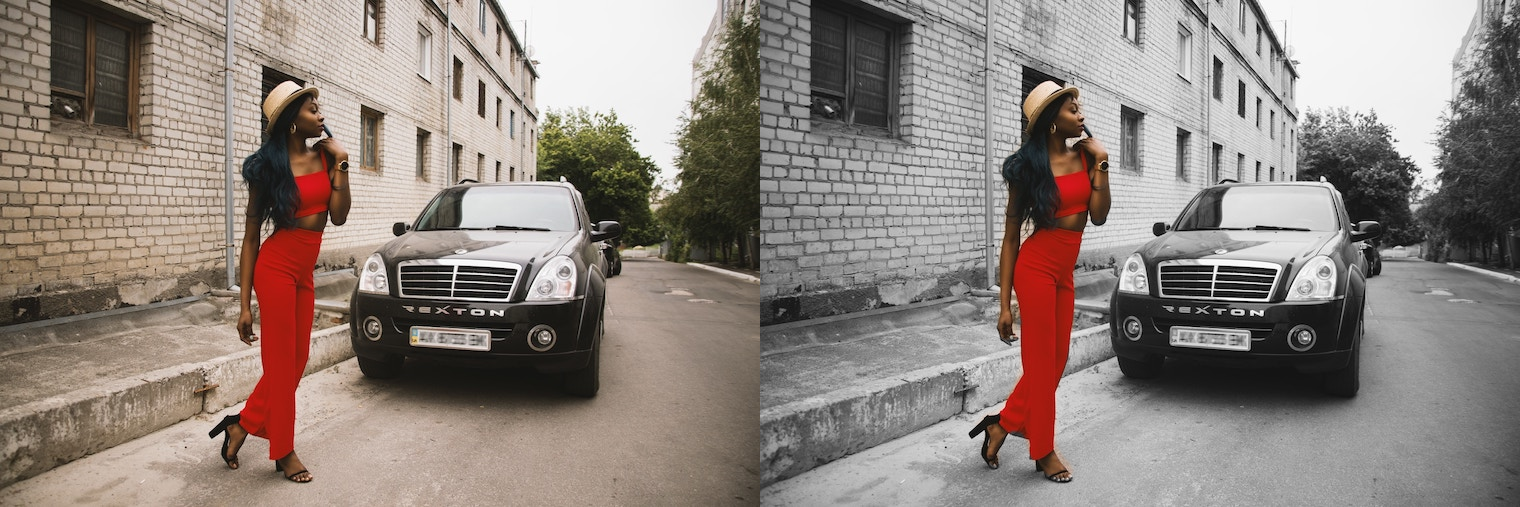

In [44]:
# Load the foreground input image
foreground = cv2.imread("/content/drive/My Drive/woman-with-car.jpg")

# Resize image to match shape of R-band in RGB output map
foreground = cv2.resize(foreground, (rgb.shape[1],rgb.shape[0]), interpolation = cv2.INTER_AREA)


 
# Create a background image by copying foreground and converting into grayscale
background = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
 
# convert single channel grayscale image to 3-channel grayscale image
background = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB)

 
# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
 
# Create a binary mask of the RGB output map using the threshold value 0
th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
 
# Apply a slight blur to the mask to soften edges
alpha = cv2.GaussianBlur(alpha, (7,7),0)

# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255
 
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
 
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
 
# Add the masked foreground and background
outImage = cv2.add(foreground, background)
 
numpy_horizontal = np.hstack((img, outImage))

numpy_horizontal_concat = np.concatenate((img, outImage), axis=1)
# Display image
cv2_imshow(numpy_horizontal_concat)
cv2.waitKey(0)
# Save image
cv2.imwrite('res.png' , numpy_horizontal_concat)
files.download('res.png')